<a href="https://colab.research.google.com/github/Alexandre77777/data_mining/blob/main/5.%20Random%20Forest/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0%20%E2%84%968.%20Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №8. Random forest**

# Задание 1. Обучите классификатор Random Forest для решения задачи бинарной классификации: для каждого человека научиться предсказывать, выживет ли он при крушении Титаника.

Ссылка на датасет: https://www.kaggle.com/c/titanic/data

## 1. Устанавливаем зависимости

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 2. Импортируем датасет

In [304]:
data_path = "../../data/titanic/"

train_data = pd.read_csv(os.path.join(data_path, 'train.csv'))
test_data = pd.read_csv(os.path.join(data_path, 'test.csv'))

## 3. Производим разведовательный анализ данных


Получим представление о данных в датасете:

In [305]:
display(train_data.shape, test_data.shape)

(891, 12)

(418, 11)

In [306]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [113]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [114]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


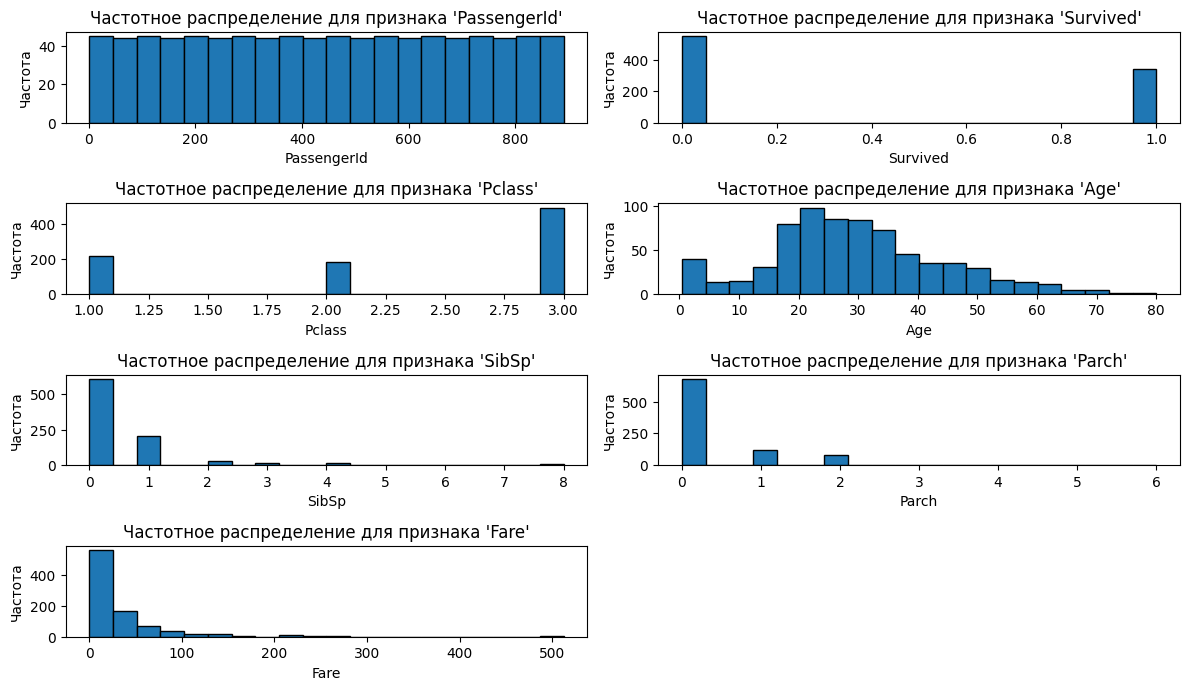

In [307]:
numerical_features = train_data.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(12, 10))

for i, column in enumerate(numerical_features.columns):
    plt.subplot(6, 2, i + 1)
    plt.hist(train_data[column], bins=20, edgecolor='k')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.title(f"Частотное распределение для признака '{column}'")

plt.tight_layout()
plt.show()

In [308]:
def check_defective_columns(df: pd.DataFrame):
    none_columns = []
    nan_columns = []

    for i, column in enumerate(df.columns):
        has_none = str(any(pd.isna(df[column])))
        has_nan = str(any(pd.isnull(df[column])))
        print(f'{column:<13} - has None: {has_none:<5} - has NaN: {has_nan:<5}')

        if (has_nan):
            nan_columns.append((i, column))

        if (has_none):
            none_columns.append((i, column))

    return none_columns, nan_columns

In [309]:
none_columns, nan_columns = check_defective_columns(train_data)

PassengerId   - has None: False - has NaN: False
Survived      - has None: False - has NaN: False
Pclass        - has None: False - has NaN: False
Name          - has None: False - has NaN: False
Sex           - has None: False - has NaN: False
Age           - has None: True  - has NaN: True 
SibSp         - has None: False - has NaN: False
Parch         - has None: False - has NaN: False
Ticket        - has None: False - has NaN: False
Fare          - has None: False - has NaN: False
Cabin         - has None: True  - has NaN: True 
Embarked      - has None: True  - has NaN: True 


In [310]:
train_data_cleaned = train_data.copy()
for i, column in none_columns:
    train_data_cleaned = train_data_cleaned[train_data_cleaned[column].notnull()]

for i, column in nan_columns:
    train_data_cleaned = train_data_cleaned[train_data_cleaned[column].notnull()]

In [311]:
none_columns, nan_columns = check_defective_columns(train_data_cleaned)

PassengerId   - has None: False - has NaN: False
Survived      - has None: False - has NaN: False
Pclass        - has None: False - has NaN: False
Name          - has None: False - has NaN: False
Sex           - has None: False - has NaN: False
Age           - has None: False - has NaN: False
SibSp         - has None: False - has NaN: False
Parch         - has None: False - has NaN: False
Ticket        - has None: False - has NaN: False
Fare          - has None: False - has NaN: False
Cabin         - has None: False - has NaN: False
Embarked      - has None: False - has NaN: False


## 4. Сформируем обучающую и тестовую выборки:


In [312]:
from sklearn.model_selection import train_test_split

# Определим целевую переменную (target) и признаки (features)
target = train_data['Survived']
features = train_data.drop(['Survived'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## 5. Feature Engineering

Поработаем с признаками, выделим важные, изменим форму их представления (при надобности)

In [316]:
age_bins = [0, 12, 18, 30, 50, float('inf')]
age_labels = ['Дети', 'Подростки', 'Средний возраст', 'От 30 до 50', 'Больше 50']
train_data['AgeGroup'] = pd.cut(train_data['Age'], bins=age_bins, labels=age_labels, right=False)
train_data = pd.get_dummies(train_data, columns=['AgeGroup'], prefix='AgeGroup')

In [317]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,AgeGroup_Дети,AgeGroup_Подростки,AgeGroup_Средний возраст,AgeGroup_От 30 до 50,AgeGroup_Больше 50,AgeGroup_Дети,AgeGroup_Подростки,AgeGroup_Средний возраст,AgeGroup_От 30 до 50,AgeGroup_Больше 50
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,False,False,True,False,False,False,False,True,False,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,False,False,False,True,False,False,False,False,True,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,False,False,True,False,False,False,False,True,False,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,False,False,False,True,False,False,False,False,True,False
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,...,False,False,True,False,False,False,False,True,False,False
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,...,False,False,True,False,False,False,False,True,False,False
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,...,False,False,False,False,False,False,False,False,False,False
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,...,False,False,True,False,False,False,False,True,False,False


In [319]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_data['Sex'] = label_encoder.fit_transform(train_data['Sex'])

In [320]:
train_data['Sex']

0      1
1      0
2      0
3      0
4      1
      ..
886    1
887    0
888    0
889    1
890    1
Name: Sex, Length: 891, dtype: int64

In [323]:
fare_bins = [0, 10, 30, 60, 100, float('inf')]
fare_labels = ['Дешево', 'Умеренно', 'Средне', 'Дорого', 'Очень дорого']
train_data['FareCategory'] = pd.cut(train_data['Fare'], bins=fare_bins, labels=fare_labels, right=False)

correlation = train_data[['FareCategory', 'Survived']].groupby('FareCategory').mean()
print(correlation)

train_data = pd.get_dummies(train_data, columns=['FareCategory'], prefix='FareCategory')

              Survived
FareCategory          
Дешево        0.199405
Умеренно      0.425397
Средне        0.500000
Дорого        0.623188
Очень дорого  0.735849


/tmp/ipykernel_14013/1357856052.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correlation = train_data[['FareCategory', 'Survived']].groupby('FareCategory').mean()


In [61]:
from sklearn.model_selection import train_test_split

selected_features = ['AgeGroup_Дети', 'AgeGroup_Подростки', 'AgeGroup_Средний возраст', 'AgeGroup_От 30 до 50', 'AgeGroup_Больше 50', 'FareCategory_Дешево', 'FareCategory_Умеренно', 'FareCategory_Средне', 'FareCategory_Дорого', 'FareCategory_Очень дорого', 'Sex']
selected_data = train_data[selected_features]
target = train_data['Survived']

X_train, X_val, y_train, y_val = train_test_split(selected_data, target, test_size=0.2, random_state=42)

In [108]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 331 to 102
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   AgeGroup_Дети              712 non-null    bool 
 1   AgeGroup_Дети              712 non-null    bool 
 2   AgeGroup_Дети              712 non-null    bool 
 3   AgeGroup_Дети              712 non-null    bool 
 4   AgeGroup_Подростки         712 non-null    bool 
 5   AgeGroup_Подростки         712 non-null    bool 
 6   AgeGroup_Подростки         712 non-null    bool 
 7   AgeGroup_Подростки         712 non-null    bool 
 8   AgeGroup_Средний возраст   712 non-null    bool 
 9   AgeGroup_Средний возраст   712 non-null    bool 
 10  AgeGroup_Средний возраст   712 non-null    bool 
 11  AgeGroup_Средний возраст   712 non-null    bool 
 12  AgeGroup_От 30 до 50       712 non-null    bool 
 13  AgeGroup_От 30 до 50       712 non-null    bool 
 14  AgeGroup_От 30 до 50       71

In [62]:
display(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(712, 31)

(179, 31)

(712,)

(179,)

## 6. Построение базовой модели:

In [63]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

## 7. Оценка точности модели:

### 7.1. Напишите функцию, принимающую на вход аргументы y_pred, y_test и выполняющую визуализацию матрицы ошибок и отчета классификации

In [64]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_pred, y_test):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False, annot_kws={"size": 16})
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.title('Матрица ошибок')
    plt.show()
  
    report = classification_report(y_test, y_pred)
    print("Отчет классификации:")
    print(report)

### 7.2. Оцените точность модели:

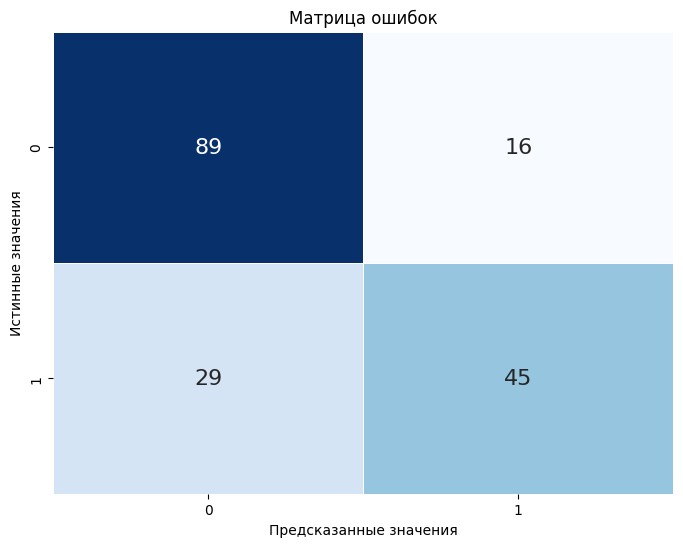

Отчет классификации:
              precision    recall  f1-score   support

           0       0.75      0.85      0.80       105
           1       0.74      0.61      0.67        74

    accuracy                           0.75       179
   macro avg       0.75      0.73      0.73       179
weighted avg       0.75      0.75      0.74       179



In [65]:
plot_confusion_matrix(y_pred, y_test)

## 8. Тюнинг гиперпараметров модели:

RandomSearchCV

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

param_dist = {
    'n_estimators': scipy.stats.randint(1, 200),
    'max_depth': scipy.stats.randint(10, 100),
    'min_samples_split': scipy.stats.randint(2, 20),
    'min_samples_leaf': scipy.stats.randint(1, 10)
}

rf = RandomForestClassifier()
random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_dist, 
    n_iter=100, 
    cv=5, 
    scoring='accuracy', 
    random_state=42
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Наилучшие гиперпараметры: {best_params}')
best_score_percent = best_score * 100
print(f'Наилучший результат: {best_score_percent:.2f}%')

Наилучшие гиперпараметры: {'max_depth': 47, 'min_samples_leaf': 6, 'min_samples_split': 14, 'n_estimators': 51}
Наилучший результат: 79.22%


GridSearchCV

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10,25, 50, 75, 100, 150],
    'max_depth': [5,10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6]
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_score_percent = best_score * 100
print(f'Наилучший результат {best_score_percent:.2f}% с параметрами {best_params}')

Наилучший результат 79.35% с параметрами {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 150}


## 9. Оценка лучшей модели:

In [68]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    'max_depth': 10, 
    'min_samples_leaf': 4, 
    'min_samples_split': 10, 
    'n_estimators': 10
}

custom_rf_model = RandomForestClassifier(**rf_params)
custom_rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=10)

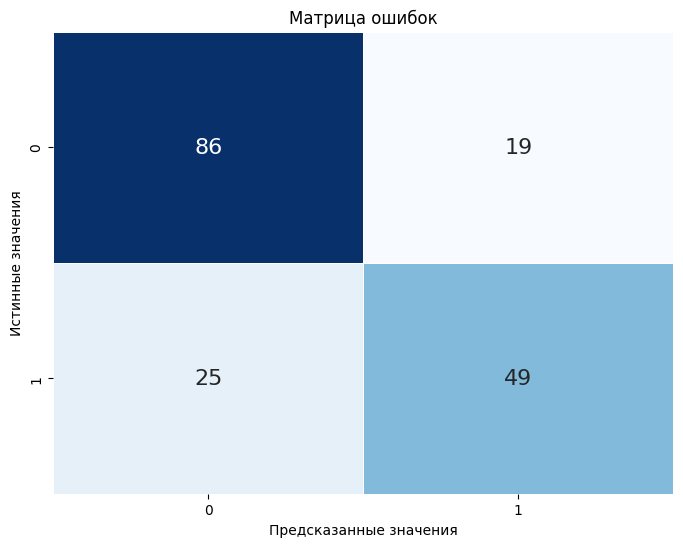

Отчет классификации:
              precision    recall  f1-score   support

           0       0.77      0.82      0.80       105
           1       0.72      0.66      0.69        74

    accuracy                           0.75       179
   macro avg       0.75      0.74      0.74       179
weighted avg       0.75      0.75      0.75       179



In [69]:
y_pred = custom_rf_model.predict(X_val)
plot_confusion_matrix(y_pred, y_test)

# Задание 2. Решите задачу из предыдущего пункта используя другие, ранее пройденные классификаторы. Сравните их точность предсказания с Random Forest

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree_model = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None,3, 5,10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4,8],
    'max_features': ['sqrt', 'log2',None],
}

grid_search_tree = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_tree.fit(X_train, y_train)

best_params_tree = grid_search_tree.best_params_
best_score_tree = grid_search_tree.best_score_

best_tree_model = DecisionTreeClassifier(**best_params_tree)
best_tree_model.fit(X_train, y_train)

print(f'Наилучшие гиперпараметры для DecisionTreeClassifier: {best_params_tree}')
best_score_tree_percent = best_score_tree * 100
print(f'Наилучший результат: {best_score_tree_percent:.2f}%')


Наилучшие гиперпараметры для DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Наилучший результат: 79.77%


# Задание 2.1*. Реализуйте функцию, для взаимодействия с обученной Вами моделью

* Функция должна принимать на вход обученную модель классификатора;

* После вызова функции, у пользователя через консоль запрашиваются значения признаков. При запросе значений нужно вывести пояснения о типе и диапазоне возможных значений. Также реализуйте обработку исключений;

* После ввода значений для всех признаков в консоль, выводится результат работы классификатора.

In [457]:
import numpy as np
import pandas as pd

def get_string_array(query: str, delim: str):
    inp = ''
    while True:
        inp = input(query + f'[delimiter: {delim}]')

        if inp == 'stop':
            return 'stop'

        try:
            res = [x.strip() for x in inp.split(delim)]
            if len(res) != 0:
                return res
        except:
            print("Couldn't get array of strings")

def get_yes_no(query: str):
    inp = input(query)

    if inp != 'yes':
        print('Aborting')
        return False
    return True

def get_int_array(query: str, delim: str):
    inp = ''
    while True:
        inp = input(query + f'[delimiter: {delim}]')

        if inp == 'stop':
            return 'stop'

        try:
            res = [int(x) for x in inp.split(delim)]
            if len(res) != 0:
                return res
        except:
            print("Couldn't get array of int")

supported_types = {
    'str': str, 
    'int': int, 
    'float': float, 
    'bool': bool
}
def get_type_input(query: str):
    inp = ''
    while True:
        inp = input(query + f'Supported types: {", ".join(supported_types)}')

        if inp == 'stop':
            return None

        if inp in supported_types.keys():
            return supported_types[inp]

        print('Invalid type')

def get_float(query: str):
    inp = ''
    while True:
        inp = input(query)

        if inp == 'stop':
            return None

        if inp != None and len(inp) != 0:
            if inp.isdecimal():
                return float(inp)
        
        print('Invalid float')

def get_int(query: str):
    inp = ''
    while True:
        inp = input(query)

        if inp == 'stop':
            return None

        if inp != None and len(inp) != 0:
            if inp.isdigit():
                return int(inp)
        
        print('Invalid int')

def get_ne_string(query: str):
    inp = ''
    while True:
        inp = input(query)

        if inp == 'stop':
            return None

        if inp != None and len(inp) != 0:
            return inp
        
        print('Invalid string')

# Костыль, т.к. отсутсвует явный конструктор у dtype
# Для того, чтобы преобразовать динамически элемент 
# к нужному типу, мы делаем следующее:
#
# 1.   Получаем строковый ввод. Берем нужную колонку, получаем из неё dtype
# 1.1. Если тип строка - игнорируем преобразования и возвращаем всё как есть
# 2.   Создаем NumPy массив с нужным типом. Массив умеет сам конвертировать значения, 
# или же нам выкинет ошибку
# 3.   Берем первый элемент массива
def str_to_col_type(inp: str, dt: np.dtype):
    # We assume that object is string
    if dt.name == 'object':
        inp = inp.rstrip("'").lstrip("'")
        return inp
    
    return np.array([inp], dtype=dt)[0]

# ---------------------------------
# DEFAULT SHAPE (0) FOR ALL ARRAYS
# ---------------------------------
# def get_shape(query: str):
#     inp = ''
#     while True:
#         inp = input(query)

#         if inp == 'stop':
#             return None
        
#         try:
#             inp = inp.lstrip('(').rstrip(')')
            
#             print(f'input shape: {inp}')
#             res = tuple([int(x) for x in inp.split(',')])
#             if len(res) != 0:
#                 return res
#         except:
#             print("Couldn't get tuple")

class DataInputManager():
    dataset = pd.DataFrame()
    df_col_preprocess = dict()
    commands = dict()
    target_column = ''
    # train_split_ratio = 0.1

    def try_run(self, command):
        if command not in self.commands.keys():
            print('No such command')
        
        try:
            self.commands[command]['runner'](self)
        except Exception as e:
            print(f'Error: {e}. Aborting')

    def help(self):
        for key, value in self.commands.items():
            print(f"Command: {key}, description: {value['description']}")

    def info(self):
        assert len(self.dataset.columns) != 0, 'No data'
        print(self.dataset.info())
        for col in self.dataset.columns:
            prep_info = self.df_col_preprocess[col]
            if prep_info['type'] == 'Range':
                print(f"{prep_info['column']} bounds: {prep_info['bounds']}")

    def head(self):
        assert len(self.dataset.columns) != 0, 'No data'
        display(self.dataset.head())

    def select_target(self):
        assert len(self.dataset.columns) != 0, 'No data'

        inp = ''
        while inp != 'stop':
            print(f'Available columns:')
            for col in self.dataset.columns.array:
                print(col)

            inp = input('Enter name of column: [stop]') 
            if inp in self.dataset.columns:
                print(f'Selected {inp}')
                self.target_column = inp
                return
            
            print('Invalid column name')

        if inp == 'stop':
            print('Canceled')

    def create(self):
        cols = get_string_array('Enter column names, separeted by comma', ',')
        if cols == ['stop']:
            print('Cancelled')
            return
        assert len(cols) == len(set(cols)), 'Duplicates exists'
        col_types = []
        for col in cols:
            col_type = get_type_input(f'Inter type for {col}: ')
            col_types.append(col_type)
        
        assert len(col_types) == len(cols), 'Column names and column types count do not match'
        print(cols, col_types)
        for col, typ in zip(cols, col_types):
            if typ == str:
                self.df_col_preprocess[col] = {
                    'column': col,
                    'type': 'LabelEncoder'
                }
            elif typ == int:
                bounds = get_int_array('Enter ranges boundries', ',')
                labels = get_string_array('Enter ranges bounds labels', ',')

                assert len(bounds) == len(labels), 'Ranges boundries array length and labels array length do not match'

                add_inf_bounds = get_yes_no('Add float("-inf")/float("inf") at the start and at the end of range?')
                if add_inf_bounds:
                    bounds = [float('-inf')] + bounds + [float('inf')]
                    border_labels = get_string_array('Enter label for first and last element (must be 2 elements):', ',')
                    assert len(border_labels) == 2, f'Expected 2 elements. Entered: {len(border_labels)}'
                    labels = [border_labels[0]] + labels + [border_labels[-1]]
                    assert len(bounds) == len(labels), 'Ranges boundries array length and labels array length do not match (after inf append)'

                self.df_col_preprocess[col] = {
                    'column': col,
                    'type': 'Range',
                    'bounds': bounds,
                    'labels': labels
                }
            new_series = pd.Series(np.empty(dtype=typ, shape=(0,)))
            self.dataset[col] = new_series

    def clear_dataset(self):
        if get_yes_no("Are you sure? [no]"):
            self.dataset = pd.DataFrame()
            print('Done')
            return
        
        print('Aborting')

    def add_rows(self):
        assert len(self.dataset.columns) != 0, 'No data'

        inp = ''
        while inp != 'stop':
            inp = get_string_array('Enter row values separated by ;', ';')

            if inp == 'stop':
                print('Stopping rows input')
                return

            if inp is None or len(inp) == 0:
                print('Empty input')
                continue

            if len(inp) != len(self.dataset.columns):
                print('Length of input row does not match to dataset columns count')
                continue

            row_els = []
            dataset_types = [self.dataset[col].dtype for col in self.dataset.columns]
            for el, col_type in zip(inp, dataset_types):
                converted_el = str_to_col_type(el, np.dtype(col_type))
                row_els.append(converted_el)

            self.dataset.loc[len(self.dataset)] = row_els

    # def set_train_split_ratio(self):
    #     new_ratio = get_float()
    #     if new_ratio is None:
    #         print('Aborting')
    #         return
        
    #     self.train_split_ratio = new_ratio
            

    def preprocess(self):
        assert len(self.dataset.columns) != 0, 'No data'
        assert len(self.dataset) != 0, 'No values'
        assert self.target_column != '', 'Target column not set'

        features_columns = []

        prep_dataset = self.dataset.copy()
        for key, value in self.df_col_preprocess.items():
            prep = self.df_col_preprocess[key]
            column = prep['column']
            if prep['type'] == 'LabelEncoder':
                label_encoder = LabelEncoder()
                prep_dataset[column] = label_encoder.fit_transform(prep_dataset[column])
                features_columns.append(column)
            elif prep['type'] == 'Range':
                bounds = prep['bounds']
                bounds_labels = prep['labels']
                prep_dataset[column] = pd.cut(
                    prep_dataset[column], 
                    bins=bounds, 
                    labels=bounds_labels, 
                    right=False
                )
                prep_dataset = pd.get_dummies(prep_dataset, columns=column, prefix=column)
                new_columns = [x + '_' + y for x, y in zip(bounds_labels, bounds)]
                features_columns.extend(new_columns)

        # return train_test_split(
        #     self.dataset, 
        #     self.dataset[self.target_column], 
        #     test_size=self.train_split_ratio
        # )
        features_columns.remove(self.target_column)
        return prep_dataset[features_columns], prep_dataset[self.target_column]
                
    commands = {
        'help': {
            'description': 'Help command',
            'runner': help
        },

        'info': {
            'description': 'Print dataset info',
            'runner': info
        },

        'head': {
            'description': 'Print head of dataframe',
            'runner': head
        },

        'select_target': {
            'description': 'Select column which containes target values',
            'runner': select_target
        },
        
        'clear': {
            'description': 'Clear current dataset',
            'runner': clear_dataset
        },

        'create': {
            'description': 'Create new dataframe with entered column names and dtypes',
            'runner': create
        },

        'add': {
            'description': 'Add rows to dataset',
            'runner': add_rows
        },

        # 'set_split_ratio': {
        #     'description': 'Set train and test split ratio',
        #     'runner': set_train_split_ratio
        # },

        'preprocess': {
            'description': 'Execute data preprocess and return train and test data',
            'runner': preprocess
        },
    }

In [458]:
proc = DataInputManager()

In [467]:
from IPython.display import clear_output
import time

def input_and_classify(model):
    inp = ''
    while inp != 'stop':
        inp = input('Enter command: ')
        
        clear_output(wait=True)

        if inp == 'stop':
            print('Stopping...')
            return
        
        if inp == 'preprocess':
            print('Starting preprocess')
            break
        
        proc.try_run(inp)
        time.sleep(0.2) # иначе не успевает отработать clear_output()

    X_train, y_train = proc.preprocess()
    y_pred = model.predict(X_train)
    print(y_pred)
    

In [460]:
from sklearn.metrics import accuracy_score

data = '../../data/car_evaluation/car_evaluation.csv'
df = pd.read_csv(data, header=None)

col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df.columns = col_names

# Уберем несколько меток, чтобы было проще вводить данные
needed_col_names = ['buying', 'maint', 'safety', 'class']
df = df[needed_col_names]

X = df.drop(['class'], axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

le = LabelEncoder()
for colsn in X_train.columns:
    X_train[colsn] = le.fit_transform(X_train[colsn].astype(str))

for colsn in X_test.columns:
    X_test[colsn] = le.fit_transform(X_test[colsn].astype(str))

rfc_100 = RandomForestClassifier(n_estimators=100, random_state=0)
rfc_100.fit(X_train, y_train)
y_pred_100 = rfc_100.predict(X_test)
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred_100)))

Model accuracy score with 100 decision-trees : 0.7268


In [461]:
for col in df.columns:
    print(df[col].value_counts())   

buying
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64
maint
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64
safety
low     576
med     576
high    576
Name: count, dtype: int64
class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64


In [462]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1157 entries, 48 to 1126
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   buying  1157 non-null   int64
 1   maint   1157 non-null   int64
 2   safety  1157 non-null   int64
dtypes: int64(3)
memory usage: 36.2 KB


In [463]:
df.head(5)

,buying,maint,safety,class
0,vhigh,vhigh,low,unacc
1,vhigh,vhigh,med,unacc
2,vhigh,vhigh,high,unacc
3,vhigh,vhigh,low,unacc
4,vhigh,vhigh,med,unacc


Использование функции `input_and_classify(model)`:

1. Вызвать команду `create`
    - Ввести список нужных колонок через запятую (пример: `buying, maint, safety, class`)
    - Для каждой колонки ввести тип
        - Если тип `bool`: ничего делать не нужно;
        - Если тип `str`: ничего делать не нужно, по умолчанию используется `LabelEncoder`;
        - Если тип `int` или `float`: предложит через запятую ввести границы категорий для признака и метку для каждой категории. 

Таким образом будет создан `DataFrame` с заданными параметрами. Посмотреть его можно вызвав команды `info` и `head`.

2. Вызвать команду `add`. Далее нужно через точку с запятой вводить соответствующие колонкам значения. Если вводимый тип строка - нужно обязательно заключить ввод в кавычки. (пример: `'vhigh';'vhigh';'low';'unacc'`).

Значения можно вводить бесконечно долго. Остановить процесс можно вписав `stop`

3. Задать колонку с целевыми зачениями через команду `set_target_column`. После вызова предложит ввести название нужной колонки

4. Вызвать команду `preprocess`. Таким образом будут провежены все промежуточные этапы по предобработке `DataFrame`. Этоговый результат будет передан классификатору. Ячейка выведет результат работы классификатор

Если объект `proc` не был проинициализирован заново (или ядро не было перезагружено), то можно продолжить ввод значений, запустив ячейку заново и вызвав команду `add`. 

Можно очистить введенный датасет вызвав команду `clear`. Необходимо подтвердить это действие, написав `yes`

In [468]:
input_and_classify(rfc_100)

Starting preprocess
['acc']


# Задание 3. Решите задачу регрессии, используя [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

* Для выполнения данного задания можете использовать **любой датасет**



Использованный датасет: https://www.kaggle.com/datasets/nsrose7224/crowdedness-at-the-campus-gym

Цель - предсказать загруженность спортзала по предоставленным данным

In [507]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# Load data

In [500]:
df = pd.read_csv("../../data/crowdness_at_campus_gym/data.csv")
df = df.drop('date', axis=1)

In [501]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   timestamp             62184 non-null  int64  
 2   day_of_week           62184 non-null  int64  
 3   is_weekend            62184 non-null  int64  
 4   is_holiday            62184 non-null  int64  
 5   temperature           62184 non-null  float64
 6   is_start_of_semester  62184 non-null  int64  
 7   is_during_semester    62184 non-null  int64  
 8   month                 62184 non-null  int64  
 9   hour                  62184 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 4.7 MB


# Feature engineering

Используем one-hot-encoding для дней недели

In [502]:
columns = ["day_of_week", "month", "hour"]
df = pd.get_dummies(df, columns=columns)
df.head(5)

,number_people,timestamp,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,day_of_week_0,day_of_week_1,day_of_week_2,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,37,61211,0,0,71.76,0,0,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,45,62414,0,0,71.76,0,0,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,40,63015,0,0,71.76,0,0,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,44,63616,0,0,71.76,0,0,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,45,64217,0,0,71.76,0,0,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [503]:
data = df.values

# В первой колонке находятся целевые значения
X = data[:, 1:]
y = data[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [504]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Training

In [505]:
model = RandomForestRegressor(n_jobs=-1)

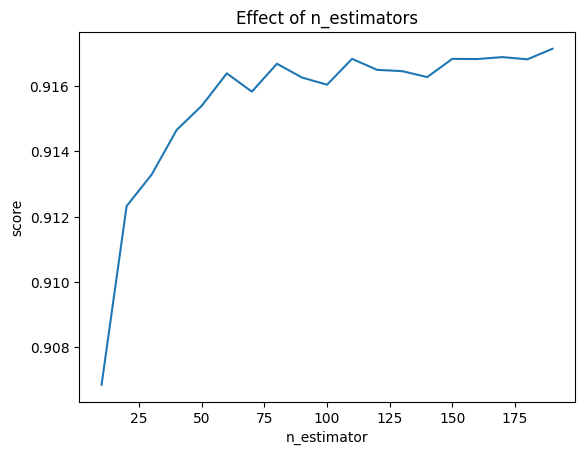

In [506]:
# Переберем различные значения n_estimators
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)